In [1]:
using Revise
using HypergraphNB
using DataFrames
using Clustering
using Statistics
using RCall
using Arpack
using Plots
using StatsBase
using SparseArrays
using Kronecker: ⊗
using LinearAlgebra
using SparseArrays

┌ Info: Precompiling HypergraphNB [2dbe4ab3-0c84-4f8d-86d2-f64d6d698dce]
└ @ Base loading.jl:1260
┌ Warning: Package HypergraphNB does not have StatsBase in its dependencies:
│ - If you have HypergraphNB checked out for development and have
│   added StatsBase as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with HypergraphNB
└ Loading StatsBase into HypergraphNB from project dependency, future warnings for HypergraphNB are suppressed.


In [2]:
n  = 100
c₂ = 5
c₃ = 5
z  = 1 .+ (1:n .> n/2);

p₂ = 0.7
p₃ = 0.9

H = detectabilityData(n, c₂, c₃, p₂, p₃);

In [3]:
BP_mat, ix = BPJacobian(H, z); 

In [4]:
@time E = Arpack.eigs(BP_mat; nev = 3, ritzvec = true, tol = 1e-10);

  2.536503 seconds (7.25 M allocations: 379.061 MiB, 5.11% gc time)


# BP Jacobian Reduction: main check

First, let's compute the true spectrum of the BP Jacobian. This is the spectrum which we would like to reproduce in a reduced version of the matrix. 

In [20]:
BP_mat, ix = BPJacobian(H, z);
@time E = Arpack.eigs(BP_mat; nev = 100);

  0.265493 seconds (2.04 k allocations: 22.364 MiB)


In [21]:
B_ = reducedBPJacobian(H, z);
@time E_  = Arpack.eigs(B__; nev = 100, ritzvec = true, tol = 1e-10);

forming main blocks
d
  0.112755 seconds (1.63 k allocations: 9.590 MiB)


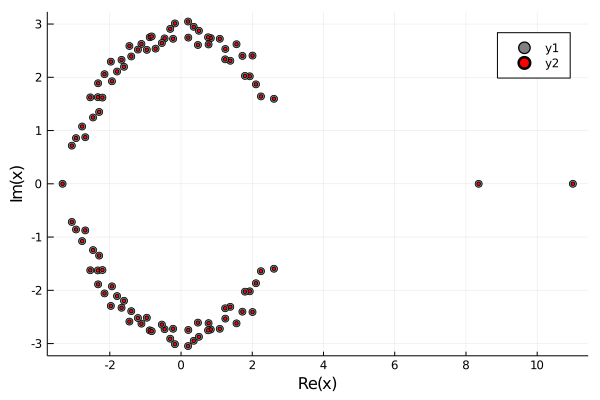

In [22]:
plot(E[1], seriestype = :scatter, color = "grey")
plot!(E_[1], seriestype = :scatter, markersize = 2, color = "red")
# plot!(xlim = (-1, 1), ylim = (-1, 1))

# Checking Relations

In this notebook, we are going to see whether we can manually check the relations written out in the document for the vectors $\alpha$ and $\beta$. These might be kind of tedious, but it should be a start...

In [6]:
v = E[2][:,2]
α = HypergraphNB.sumEigenvector(v, ix, "out");
β = HypergraphNB.sumEigenvector(v, ix, "in");

In [7]:
ℓ = 2
K = sort(collect(keys(H.E)))
K_ = sort(collect(keys(H.E)))
function convertIndex(i, k, s)
    k̄ = length(K)
    kix = Dict(K[i] => i for i ∈ 1:k̄)
    return i + (kix[k]-1)*n + (s-1)*k̄*n
end

convertIndex (generic function with 1 method)

In [8]:
# building blocks
D = HypergraphNB.degreeMatrix(H);
A = HypergraphNB.adjacencyBlockMatrix(H)


c, G = degreeTensor(H, z);
ẑ = z
q = 1/n * StatsBase.counts(ẑ)
G_ = zero(G)
for i ∈ 1:length(K)
    G_[i,:,:] = (G[i,:,:] / ((K[i] - 1) * c[i]) .- 1) .* q
end

MethodError: MethodError: no method matching degreeMatrix(::hypergraph)
Closest candidates are:
  degreeMatrix(::hypergraph, !Matched::Any) at /home/phil/HyperCommDetect/HypergraphNB/src/matrices.jl:167
  degreeMatrix(::Any, !Matched::Any, !Matched::Any) at /home/phil/HyperCommDetect/HypergraphNB/src/matrices.jl:150

## First relation

In [9]:
function firstRelation(α, β)
    v = zero(α)
    # indexing in k
    k̄ = length(K)
    kix = Dict(K[i] => i for i ∈ 1:k̄)

    for i ∈ 1:n, k ∈ K, s ∈ 1:ℓ

        # index in v to populate
        ix = convertIndex(i, k, s)

        d_ik = D[i + (kix[k]-1)*n, i + (kix[k]-1)*n]

        for t ∈ 1:ℓ
            for k_ ∈ K    
                v[ix] += d_ik * G_[kix[k_], s, t] * β[convertIndex(i, k_, t)]
            end
            v[ix] -= G_[kix[k], s, t] * β[convertIndex(i, k, t)]
        end
    end
    return v
end

v = firstRelation(α, β);

In [10]:
# ok, this looks good! Nice start. 
# first relation is correct, still questions 
# about how to get things into matrices but for now we can check
# the second relation

test = v ./ α 
var(test[1 .- isnan.(test) .== 1])

8.461714497668145e-28

In [11]:
(v ./ α)[1], E[1][2]

(7.330100700281418, 7.330100700281403 + 0.0im)

## Second Relation

In [12]:
function secondRelation(α, β)

    u = zero(β)

    k̄ = length(K)
    kix = Dict(K[i] => i for i ∈ 1:k̄)

    for i ∈ 1:n, k ∈ K, s ∈ 1:ℓ

        # index in v to populate
        ix = convertIndex(i, k, s)

        # first term
        for t ∈ 1:ℓ
            for k_ ∈ K    
                for j ∈ 1:n
                    A_kij = A[i+(kix[k]-1)*n, j+(kix[k]-1)*n]
                    u[ix] += G_[kix[k_], s, t]*A_kij*β[convertIndex(j, k_, t)]
                end
            end
            ix_ = convertIndex(i, k, t)
            u[ix] -= G_[kix[k], s, t] * ((k-1)*α[ix_] + (k-2)*β[ix_])
        end
    end
    return u
end

u = secondRelation(α, β);

In [13]:
# second relation is also correct
# so our task is literally just to turn these into matrices
# one approach would be to form the required matrix from the standard basis...

test = u ./ β
var(test[1 .- isnan.(test) .== 1])

2.5715431945717324e-26

# Kludgy approach to getting the right matrix

A viable strategy here would be to adapt these loops so that they form the required matrix by simply acting on the standard basis...

In [14]:
# eventually want this to be sparse, but dense is ok for now
# takes a while to run

k̄ = length(K)

B_ = zeros(2*n*k̄*ℓ, 2*n*k̄*ℓ); 

for i ∈ 1:(2*n*k̄*ℓ)
    
    if i % 50 == 0
        println(i)
    end
    
    basis_vec = zeros(2*n*k̄*ℓ)
    basis_vec[i] = 1.0
    
    α, β = basis_vec[1:(n*k̄*ℓ)], basis_vec[(n*k̄*ℓ+1):(2*n*k̄*ℓ)]
    
    u = firstRelation(α, β)
    v = secondRelation(α, β)
    
    B_[:,i] = vcat(u, v)    
end

50
100
150
200
250
300
350
400


In [15]:
E_ = Arpack.eigs(B_; nev = 3, ritzvec = true, tol = 1e-10);

In [16]:
E_[1]

3-element Array{Complex{Float64},1}:
  10.63122839453785 + 0.0im
  7.330100700281389 + 0.0im
 -3.802779745593465 + 0.0im

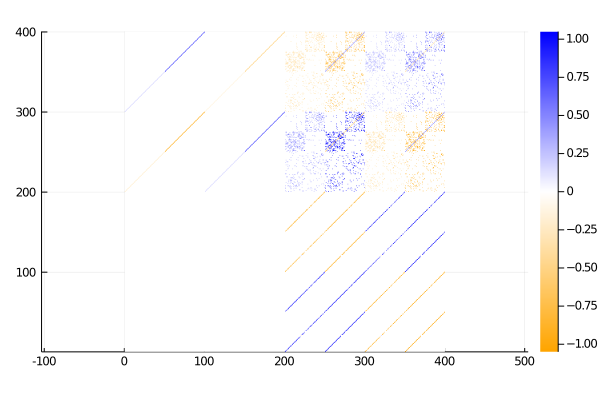

In [17]:
heatmap(B_, 
    c = cgrad([:orange, :white, :blue], [-1.0, 0.0, 1.0]), 
    clims=(-1.05,1.05), aspect_ratio=:equal)

Let's compare! 

In [18]:
# diagonal matrix of edge sizes
K = diagm(K_)

n = length(H.D)

# degree diagonal matrix

d = [HypergraphNB.degreeMatrix(H, k) for k ∈ K_]
D = cat(d..., dims = (1, 2))

# adjacency matrix (diagonal)
a = [HypergraphNB.adjacencyMatrix(H, k) for k ∈ K_]
A = cat(a..., dims = (1, 2));

K_ = sort(collect(keys(H.E)))
c, G = degreeTensor(H, z);
ẑ = z
q = 1/n * StatsBase.counts(ẑ)
G_ = zero(G)
for i ∈ 1:length(K_)
    G_[i,:,:] = (G[i,:,:] / ((K_[i] - 1) * c[i]) .- 1) .* q
end

In [19]:
# make dC

k̄ = length(K_)

dC = zeros(k̄*ℓ, k̄*ℓ)

for k ∈ 1:k̄, s ∈ 1:ℓ, t ∈ 1:ℓ
    dC[k + (s-1)*k̄, k + (t-1)*k̄] = G_[k, s, t]
end

dC

4×4 Array{Float64,2}:
  0.236842   0.0       -0.201754   0.0
  0.0        0.544177   0.0       -0.427711
 -0.201754   0.0        0.166667   0.0
  0.0       -0.427711   0.0        0.311245

In [20]:
# make C
C = zeros(k̄*ℓ, k̄*ℓ)

for k ∈ 1:k̄, s ∈ 1:ℓ, t ∈ 1:ℓ, k_ ∈ 1:k̄
    C[k + (s-1)*k̄, k_ + (t-1)*k̄] = G_[k, s, t]
end
C

4×4 Array{Float64,2}:
  0.236842   0.236842  -0.201754  -0.201754
  0.544177   0.544177  -0.427711  -0.427711
 -0.201754  -0.201754   0.166667   0.166667
 -0.427711  -0.427711   0.311245   0.311245

In [21]:
ℓ = length(unique(z))

# # upper-right block? 

upperRight = (sparse(C ⊗ I(n)) * sparse(I(ℓ) ⊗ D) - sparse(dC ⊗ I(n)))'
lowerLeft  = sparse((dC * (I(ℓ)⊗(I - K))) ⊗ I(n))';
lowerRight = (sparse(C ⊗ I(n)) * (I(ℓ) ⊗ A)   - (dC*(I(ℓ)⊗(K - 2I)))⊗I(n))';

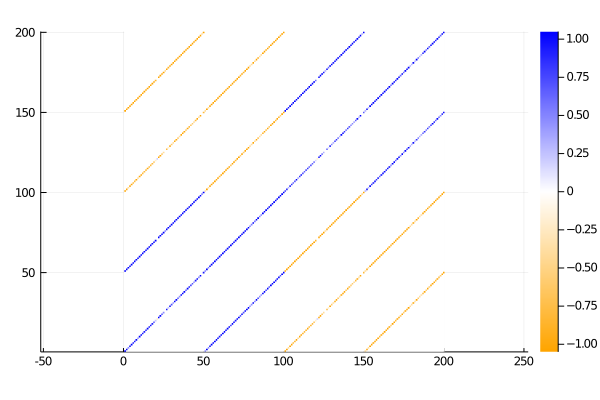

In [22]:
test = Matrix(sparse(C ⊗ I(n)) * sparse(I(ℓ) ⊗ D) - sparse(dC ⊗ I(n)))

heatmap(test,     
    c = cgrad([:orange, :white, :blue], [-1.0, 0.0, 1.0]), 
    clims=(-1.05,1.05), aspect_ratio=:equal) 

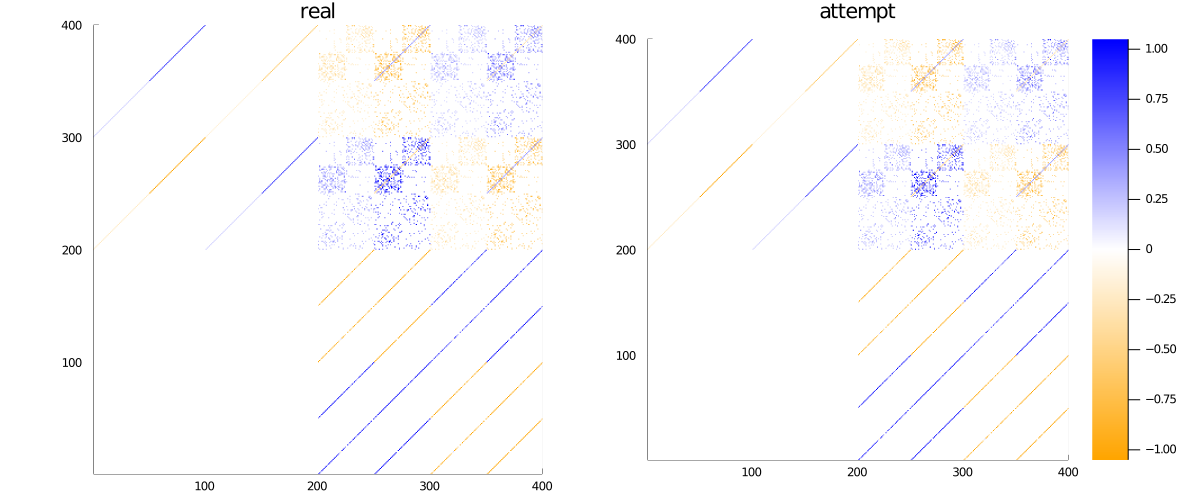

In [23]:
# the attempt
B̃ = hcat(zero(upperRight), upperRight);
B̃ = vcat(B̃, hcat(lowerLeft, lowerRight));

h2 = heatmap(Matrix(B̃), 
    c = cgrad([:orange, :white, :blue], [-1.0, 0.0, 1.0]), 
    clims=(-1.05,1.05), aspect_ratio=:equal, xlim = (1, 8*n), ylim = (1, 8*n), title = "attempt")

h1 = heatmap(B_, 
    c = cgrad([:orange, :white, :blue], [-1.0, 0.0, 1.0]), 
    clims=(-1.05,1.05), aspect_ratio=:equal, xlim = (1, 8*n), ylim = (1, 8*n), title = "real", legend = :none)

plot(h1, h2, size = (1200, 500))

Ok, so obviously this is *very* close, but we have a small amount of tweaking to do. I do suspect that this is related to the construction of the matrices C and dC, as this in turn is connected to the order in which the indices change. 

In [24]:
E = Arpack.eigs(BP_mat; nev = 3, ritzvec = true, tol = 1e-10);
E_ = Arpack.eigs(B_; nev = 3, ritzvec = true, tol = 1e-10);
Ẽ  = Arpack.eigs(B̃; nev = 3, ritzvec = true, tol = 1e-10);

In [25]:
E[1]

3-element Array{Complex{Float64},1}:
  10.631228394537882 + 0.0im
    7.33010070028141 + 0.0im
 -3.8027797454928924 + 0.0im

In [26]:
E_[1]

3-element Array{Complex{Float64},1}:
  10.631228394537851 + 0.0im
   7.330100700281405 + 0.0im
 -3.8027797455108394 + 0.0im

In [27]:
Ẽ[1]

3-element Array{Complex{Float64},1}:
  10.63122839453786 + 0.0im
  7.330100700281393 + 0.0im
 -3.802779745513019 + 0.0im

In [9]:
B__ = reducedBPJacobian(H, z);

forming main blocks
d


In [10]:
size(B__)

(800, 800)

In [11]:
@time E__  = Arpack.eigs(B__; nev = 3, ritzvec = true, tol = 1e-10);
E__[1]

  1.117509 seconds (3.13 M allocations: 154.881 MiB, 4.67% gc time)


3-element Array{Complex{Float64},1}:
  11.001776459983184 + 0.0im
   8.356708093479677 + 0.0im
 -3.3255472319520525 + 0.0im